In [ ]:
=v              IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

vardhan1536_new_vast_path = kagglehub.dataset_download('vardhan1536/new-vast')

print('Data source import complete.')


# Zero Shot Stance Detection Using Contrastive Learning and Reinforcement Learning

Importing all necessary Libraries

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.distributions import Categorical
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix)
from tqdm.notebook import tqdm
import random
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
MODEL_NAME = "princeton-nlp/sup-simcse-bert-base-uncased"
OUTPUT_DIR = "./stance_detection_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

MAX_LENGTH = 128
SEED = 42

In [ ]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## Contrastive Learning Part

In [ ]:
df_train = pd.read_csv('/kaggle/input/new-vast/VAST_train_11k (1).csv')
df_val = pd.read_csv('/kaggle/input/new-vast/VAST_val (1).csv')
df_test = pd.read_csv('/kaggle/input/new-vast/VAST_test (1).csv')

def preprocess_df(df, is_test=False):
    df = df[['Tweet', 'Target 1', 'Stance 1']].dropna()
    df.columns = ['tweet', 'target', 'stance']
    df['stance'] = df['stance'].str.upper().str.strip()
    valid_stances = ['FAVOR', 'AGAINST', 'NONE']
    df = df[df['stance'].isin(valid_stances)]

    df['contrastive_input'] = df['tweet'] + ' [SEP] ' + df['target']
    return df.reset_index(drop=True)

df_train = preprocess_df(df_train)
df_val = preprocess_df(df_val)
df_test = preprocess_df(df_test)

print(f"Train samples: {len(df_train)}, Val samples: {len(df_val)}, Test samples: {len(df_test)}")
print("Train stance distribution:\n", df_train['stance'].value_counts())

# Stance Mapping
stance_to_id = {'FAVOR': 0, 'AGAINST': 1, 'NONE': 2}
id_to_stance = {v: k for k, v in stance_to_id.items()}
NUM_ACTIONS = len(stance_to_id)


Loading and preprocessing data...
Train samples: 11305, Val samples: 2062, Test samples: 3006
Train stance distribution:
 stance
AGAINST    4507
FAVOR      4302
NONE       2496
Name: count, dtype: int64


### Preference Pairs Generation

In [ ]:

MAX_PAIRS_PER_GROUP = 5000
MAX_NEG_PAIRS_PER_TARGET = 10000

positive_pairs = []
negative_pairs = []
stance_groups = df_train.groupby(['target', 'stance'])

for (target, stance), group in tqdm(stance_groups, desc="Generating Positive Pairs"):
    inputs = group['contrastive_input'].tolist()
    count = 0
    for a, b in combinations(inputs, 2):
        if count >= MAX_PAIRS_PER_GROUP: break
        positive_pairs.append((a, b, 1))
        count += 1

targets = df_train['target'].unique()
for target in tqdm(targets, desc="Generating Negative Pairs"):
    subset = df_train[df_train['target'] == target]
    stances = subset['stance'].unique()
    if len(stances) < 2: continue

    stance_to_inputs = {s: subset[subset['stance'] == s]['contrastive_input'].tolist() for s in stances}
    neg_count_target = 0
    processed_pairs = set()

    for s_idx_a, stance_a in enumerate(stances):
        if neg_count_target >= MAX_NEG_PAIRS_PER_TARGET: break
        for s_idx_b, stance_b in enumerate(stances):
            if stance_a == stance_b: continue
            if neg_count_target >= MAX_NEG_PAIRS_PER_TARGET: break

            a_list = stance_to_inputs[stance_a]
            b_list = stance_to_inputs[stance_b]
            if not a_list or not b_list: continue


            max_pairs_between = min(len(a_list) * len(b_list), 5000)
            sampled_count = 0
            while sampled_count < max_pairs_between and neg_count_target < MAX_NEG_PAIRS_PER_TARGET:
                a = random.choice(a_list)
                b = random.choice(b_list)
                pair_key = tuple(sorted((a, b)))
                if pair_key not in processed_pairs:
                    negative_pairs.append((a, b, 0))
                    processed_pairs.add(pair_key)
                    neg_count_target += 1
                    sampled_count += 1

                if len(processed_pairs) > len(a_list) * len(b_list) * 0.95:
                    break


print(f"Positive pairs: {len(positive_pairs)}, Negative pairs: {len(negative_pairs)}")
all_pairs = positive_pairs + negative_pairs
random.shuffle(all_pairs)
pairs_df = pd.DataFrame(all_pairs, columns=['text1', 'text2', 'label'])
print(f"Total contrastive pairs: {len(pairs_df)}")


--- Stage 1: Contrastive Learning ---
Generating contrastive pairs...


Generating Positive Pairs:   0%|          | 0/5928 [00:00<?, ?it/s]

Generating Negative Pairs:   0%|          | 0/4569 [00:00<?, ?it/s]

Positive pairs: 36923, Negative pairs: 30996
Total contrastive pairs: 67919


### Contrastive Dataset and DataLoader

In [ ]:

CONTRASTIVE_BATCH_SIZE = 32

class ContrastiveStanceDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return {
            'text1': row['text1'],
            'text2': row['text2'],
            'label': torch.tensor(row['label'], dtype=torch.float)
        }

contrastive_dataset = ContrastiveStanceDataset(pairs_df)
contrastive_dataloader = DataLoader(contrastive_dataset, batch_size=CONTRASTIVE_BATCH_SIZE, shuffle=True)

### Embedding Function and Contrastive Loss

In [ ]:
# Model and Tokenizer
CONTRASTIVE_MARGIN = 0.5
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
contrastive_model = AutoModel.from_pretrained(MODEL_NAME).to(device)

# Embedding Function for Contrastive Learning
def get_cls_embeddings(texts, model, tokenizer, device):
    """Encodes texts independently and returns CLS embeddings."""
    if not texts: return torch.empty(0, model.config.hidden_size).to(device)
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=MAX_LENGTH).to(device)
    with torch.no_grad():
        outputs = model(**inputs, return_dict=True)
    return outputs.last_hidden_state[:, 0, :]

# Contrastive Loss
def contrastive_loss_fn(emb1, emb2, label, margin=CONTRASTIVE_MARGIN):
    cosine_sim = F.cosine_similarity(emb1, emb2)
    loss = torch.where(label.bool(), 1.0 - cosine_sim, F.relu(cosine_sim - margin))
    return loss.mean()

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

2025-04-17 14:39:42.630760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744900782.835904      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744900782.898428      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

### Training Loop - Contrastive Fine Tuning

In [ ]:

CONTRASTIVE_LR = 1e-5

optimizer_contrastive = AdamW(contrastive_model.parameters(), lr=CONTRASTIVE_LR)

CONTRASTIVE_EPOCHS = 2

contrastive_model.train()
for epoch in range(CONTRASTIVE_EPOCHS):
    total_loss = 0
    progress_bar = tqdm(contrastive_dataloader, desc=f"Contrastive Epoch {epoch + 1}/{CONTRASTIVE_EPOCHS}", leave=False)
    for batch in progress_bar:
        optimizer_contrastive.zero_grad()

        text1_list = batch['text1']
        text2_list = batch['text2']
        labels = batch['label'].to(device)

        inputs1 = tokenizer(text1_list, padding=True, truncation=True, return_tensors='pt', max_length=MAX_LENGTH).to(device)
        inputs2 = tokenizer(text2_list, padding=True, truncation=True, return_tensors='pt', max_length=MAX_LENGTH).to(device)

        outputs1 = contrastive_model(**inputs1, return_dict=True)
        outputs2 = contrastive_model(**inputs2, return_dict=True)
        emb1 = outputs1.last_hidden_state[:, 0, :]
        emb2 = outputs2.last_hidden_state[:, 0, :]

        loss = contrastive_loss_fn(emb1, emb2, labels)
        loss.backward()
        optimizer_contrastive.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(contrastive_dataloader)
    print(f"Contrastive Epoch {epoch + 1} Average Loss: {avg_loss:.4f}")

Starting contrastive fine-tuning...


Contrastive Epoch 1/2:   0%|          | 0/2123 [00:00<?, ?it/s]

Contrastive Epoch 1 Average Loss: 0.1954


Contrastive Epoch 2/2:   0%|          | 0/2123 [00:00<?, ?it/s]

Contrastive Epoch 2 Average Loss: 0.1448


In [ ]:
# Saving Contrastive Model
contrastive_model_path = os.path.join(OUTPUT_DIR, "contrastive_model.pth")
torch.save(contrastive_model.state_dict(), contrastive_model_path)
print(f"Contrastive model saved to {contrastive_model_path}")
contrastive_model.eval()

Contrastive model saved to ./stance_detection_output/contrastive_model.pth


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

### Contrastive Learning Model Evaluation

In [ ]:
def evaluate_model(model, dataloader, prediction_fn, device, description="Evaluation"):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=description):
            tweets = batch.get('tweet')
            targets = batch.get('target')
            labels = batch.get('stance')

            if tweets is None or targets is None or labels is None:
                 input_ids = batch['input_ids'].to(device)
                 attention_mask = batch['attention_mask'].to(device)
                 labels = batch['stance_idx'].cpu().tolist()

                 logits = model(input_ids, attention_mask)
                 preds = torch.argmax(logits, dim=-1).cpu().tolist()

            else:
                 labels = labels
                 preds = [prediction_fn(tweet, target, model, tokenizer, device)[0]
                          for tweet, target in zip(tweets, targets)]

            all_preds.extend(preds)
            all_labels.extend(labels)

    if isinstance(all_labels[0], (int, np.integer)):
         all_labels = [id_to_stance[idx] for idx in all_labels]
    if isinstance(all_preds[0], (int, np.integer)):
         all_preds = [id_to_stance[idx] for idx in all_preds]

    accuracy = accuracy_score(all_labels, all_preds)
    precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"\n--- {description} Results ---")
    print(f"Accuracy      : {accuracy:.4f}")
    print(f"Precision (Mac): {precision_macro:.4f}")
    print(f"Recall (Mac)  : {recall_macro:.4f}")
    print(f"F1 Score (Mac): {f1_macro:.4f}")
    print(f"F1 Score (Wgt): {f1_weighted:.4f}")

    report = classification_report(all_labels, all_preds, zero_division=0,
                                   target_names=list(stance_to_id.keys()))
    print("\nClassification Report:")
    print(report)
    cm = confusion_matrix(all_labels, all_preds, labels=list(stance_to_id.keys()))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(stance_to_id.keys()),
                yticklabels=list(stance_to_id.keys()))
    plt.xlabel('Predicted Stance')
    plt.ylabel('True Stance')
    plt.title(f'Confusion Matrix ({description})')
    plt.savefig(os.path.join(OUTPUT_DIR, f"confusion_matrix_{description.lower().replace(' ', '_')}.png"))
    plt.show()

    return {
        "accuracy": accuracy, "precision_macro": precision_macro, "recall_macro": recall_macro,
        "f1_macro": f1_macro, "f1_weighted": f1_weighted, "report": report, "cm": cm
    }


--- Evaluating Contrastive Model (Zero-Shot on Test Set) ---


Contrastive Zero-Shot:   0%|          | 0/47 [00:00<?, ?it/s]


--- Contrastive Zero-Shot Results ---
Accuracy      : 0.3866
Precision (Mac): 0.4244
Recall (Mac)  : 0.3907
F1 Score (Mac): 0.3858
F1 Score (Wgt): 0.3858

Classification Report:
              precision    recall  f1-score   support

       FAVOR       0.39      0.30      0.34      1018
     AGAINST       0.32      0.54      0.40       944
        NONE       0.57      0.33      0.42      1044

    accuracy                           0.39      3006
   macro avg       0.42      0.39      0.39      3006
weighted avg       0.43      0.39      0.39      3006



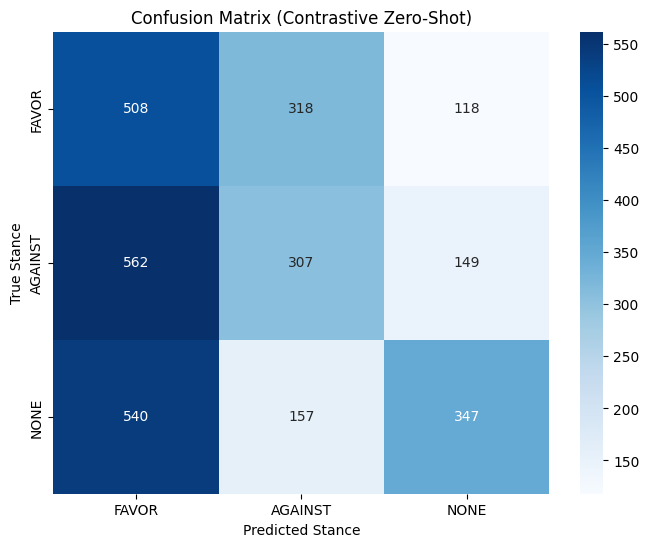

{'accuracy': 0.3865602129075183,
 'precision_macro': 0.42441921677324096,
 'recall_macro': 0.3906942604604446,
 'f1_macro': 0.38583169014155966,
 'f1_weighted': 0.385820102639468,
 'report': '              precision    recall  f1-score   support\n\n       FAVOR       0.39      0.30      0.34      1018\n     AGAINST       0.32      0.54      0.40       944\n        NONE       0.57      0.33      0.42      1044\n\n    accuracy                           0.39      3006\n   macro avg       0.42      0.39      0.39      3006\nweighted avg       0.43      0.39      0.39      3006\n',
 'cm': array([[508, 318, 118],
        [562, 307, 149],
        [540, 157, 347]])}

In [ ]:
def predict_stance_zero_shot(tweet, target, model, tokenizer, device):
    model.eval()
    input_text = f"{tweet} [SEP] {target}"
    candidate_prompts = [f"The stance towards {target} is {stance}" for stance in stance_to_id.keys()]

    input_embedding = get_cls_embeddings([input_text], model, tokenizer, device)
    prompt_embeddings = get_cls_embeddings(candidate_prompts, model, tokenizer, device)

    sims = F.cosine_similarity(input_embedding, prompt_embeddings)
    best_idx = torch.argmax(sims).item()

    predicted_stance = id_to_stance[best_idx]
    return predicted_stance, sims.squeeze().cpu().tolist()


print("\n Evaluating Contrastive Model")

class SimpleDataset(Dataset):
    def __init__(self, df): self.df = df
    def __len__(self): return len(self.df)
    def __getitem__(self, idx): return self.df.iloc[idx].to_dict()

test_dataset_simple = SimpleDataset(df_test)
test_dataloader_simple = DataLoader(test_dataset_simple, batch_size=CONTRASTIVE_BATCH_SIZE * 2)

evaluate_model(contrastive_model, test_dataloader_simple, predict_stance_zero_shot, device, "Contrastive Zero-Shot")


# Reinforcement Learning Part

### Reward Model Training Part

In [ ]:
# Generate Feedback Data using the Contrastive Model

print("Generating predictions on validation set for reward training...")
val_preds = []
for _, row in tqdm(df_val.iterrows(), total=len(df_val), desc="Predicting Val Stances"):
    pred_stance, _ = predict_stance_zero_shot(row["tweet"], row["target"], contrastive_model, tokenizer, device)
    val_preds.append(pred_stance)

df_val["predicted_stance"] = val_preds
df_val["feedback"] = (df_val["predicted_stance"] == df_val["stance"]).astype(int)

df_val["reward_input"] = df_val.apply(
    lambda r: f"Tweet: {r['tweet']} [SEP] Target: {r['target']} [PRED] {r['predicted_stance']}", axis=1
)

print("Reward model training data distribution (Feedback):")
print(df_val["feedback"].value_counts(normalize=True))


--- Stage 2: Reward Model Training ---
Generating predictions on validation set for reward training...


Predicting Val Stances:   0%|          | 0/2062 [00:00<?, ?it/s]

Reward model training data distribution (Feedback):
feedback
0    0.590204
1    0.409796
Name: proportion, dtype: float64


### Reward Dataset and DataLoader Definition

In [ ]:

REWARD_BATCH_SIZE = 16

class RewardDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        encoding = self.tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(self.labels[idx], dtype=torch.float)
        }

reward_dataset = RewardDataset(df_val["reward_input"].tolist(), df_val["feedback"].tolist(), tokenizer, MAX_LENGTH)
reward_dataloader = DataLoader(reward_dataset, batch_size=REWARD_BATCH_SIZE, shuffle=True)


### Reward Model Architecture

In [ ]:
class RewardModel(nn.Module):
    def __init__(self, encoder_path, device):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(MODEL_NAME)

        self.encoder.load_state_dict(torch.load(encoder_path, map_location=device))

        for param in self.encoder.parameters():
            param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(self.encoder.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1),
            nn.Sigmoid()
        ).to(device)


    def forward(self, input_ids, attention_mask):

        with torch.no_grad():
            outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        cls_output = outputs.last_hidden_state[:, 0]
        score = self.classifier(cls_output).squeeze(-1)
        return score

reward_model = RewardModel(contrastive_model_path, device).to(device)

/tmp/ipykernel_31/3820721378.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.encoder.load_state_dict(torch.load(encoder_path, map_location=device))


### Reward Model Training

In [ ]:

REWARD_EPOCHS = 3
REWARD_LR = 5e-5

optimizer_reward = AdamW(reward_model.classifier.parameters(), lr=REWARD_LR)
loss_fn_reward = nn.BCELoss()

reward_model.train()
reward_model.encoder.eval()

for epoch in range(REWARD_EPOCHS):
    total_loss = 0
    progress_bar = tqdm(reward_dataloader, desc=f"Reward Epoch {epoch+1}/{REWARD_EPOCHS}", leave=False)
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer_reward.zero_grad()
        scores = reward_model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn_reward(scores, labels)
        loss.backward()
        optimizer_reward.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(reward_dataloader)
    print(f"Reward Epoch {epoch+1} Average Loss: {avg_loss:.4f}")


Starting reward model training...


Reward Epoch 1/3:   0%|          | 0/129 [00:00<?, ?it/s]

Reward Epoch 1 Average Loss: 0.6821


Reward Epoch 2/3:   0%|          | 0/129 [00:00<?, ?it/s]

Reward Epoch 2 Average Loss: 0.6755


Reward Epoch 3/3:   0%|          | 0/129 [00:00<?, ?it/s]

Reward Epoch 3 Average Loss: 0.6737


### Reward Model Evaluation

Evaluating reward model on validation data...


Evaluating Reward Model:   0%|          | 0/129 [00:00<?, ?it/s]


--- Reward Model Evaluation Results ---
Accuracy : 0.5917
Precision: 0.7143 (Predicting '1' - Correct)
Recall   : 0.0059 (Predicting '1' - Correct)
F1-Score : 0.0117 (Predicting '1' - Correct)


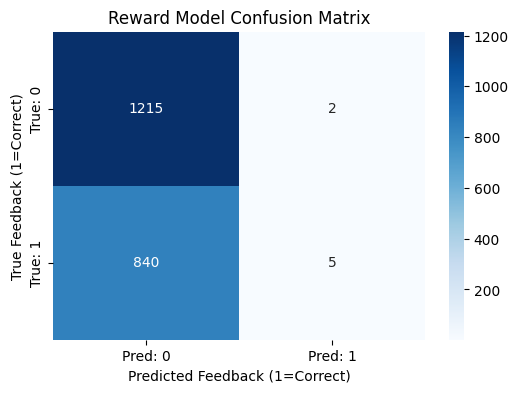

Reward model saved to ./stance_detection_output/reward_model.pth


RewardModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
reward_model.eval()
all_preds_rew = []
all_labels_rew = []
with torch.no_grad():
    for batch in tqdm(reward_dataloader, desc="Evaluating Reward Model"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].cpu().numpy()
        scores = reward_model(input_ids=input_ids, attention_mask=attention_mask)
        preds = (scores > 0.5).int().cpu().numpy()
        all_preds_rew.extend(preds)
        all_labels_rew.extend(labels)

accuracy_rew = accuracy_score(all_labels_rew, all_preds_rew)
precision_rew = precision_score(all_labels_rew, all_preds_rew, zero_division=0)
recall_rew = recall_score(all_labels_rew, all_preds_rew, zero_division=0)
f1_rew = f1_score(all_labels_rew, all_preds_rew, zero_division=0)

print("\n--- Reward Model Evaluation Results ---")
print(f"Accuracy : {accuracy_rew:.4f}")
print(f"Precision: {precision_rew:.4f} (Predicting '1' - Correct)")
print(f"Recall   : {recall_rew:.4f} (Predicting '1' - Correct)")
print(f"F1-Score : {f1_rew:.4f} (Predicting '1' - Correct)")
cm_rew = confusion_matrix(all_labels_rew, all_preds_rew)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rew, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred: 0", "Pred: 1"], yticklabels=["True: 0", "True: 1"])
plt.xlabel("Predicted Feedback ")
plt.ylabel("True Feedback")
plt.title("Reward Model Confusion Matrix")
plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix_reward.png"))
plt.show()



reward_model_path = os.path.join(OUTPUT_DIR, "reward_model.pth")

torch.save(reward_model.state_dict(), reward_model_path)
print(f"Reward model saved to {reward_model_path}")
reward_model.eval()


## PPO Training

### PPO Dataset and Dataloader

In [ ]:

PPO_BATCH_SIZE = 8

class PPODataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.df = dataframe.copy()
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.df['stance_idx'] = self.df['stance'].map(stance_to_id)

        self.df = self.df.dropna(subset=['stance_idx']).reset_index(drop=True)
        self.df['stance_idx'] = self.df['stance_idx'].astype(int)

    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        encoded = self.tokenizer(
            text=row['tweet'], text_pair=row['target'],
            max_length=self.max_length, padding="max_length",
            truncation=True, return_tensors="pt",
        )
        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'query': f"Tweet: {row['tweet']} [SEP] Target: {row['target']}",
            'stance_idx': torch.tensor(row['stance_idx'], dtype=torch.long)
        }


ppo_dataset = PPODataset(df_train, tokenizer, MAX_LENGTH)
ppo_dataloader = DataLoader(ppo_dataset, batch_size=PPO_BATCH_SIZE, shuffle=True)


--- Stage 3: PPO Training ---


### PPO Policy and Value Networks

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, encoder_path, device, num_actions):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(MODEL_NAME)
        self.encoder.load_state_dict(torch.load(encoder_path, map_location=device))

        for param in self.encoder.parameters():
            param.requires_grad = False

        self.actor = nn.Linear(self.encoder.config.hidden_size, num_actions)

        nn.init.xavier_uniform_(self.actor.weight)
        nn.init.zeros_(self.actor.bias)


    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        cls_output = outputs.last_hidden_state[:, 0]

        if torch.isnan(cls_output).any() or torch.isinf(cls_output).any():
             cls_output = torch.nan_to_num(cls_output, nan=0.0, posinf=1e6, neginf=-1e6)


        logits = self.actor(cls_output)
        logits = torch.clamp(logits, min=-10.0, max=10.0)

        return logits

class ValueNetwork(nn.Module):
    def __init__(self, encoder_path, device):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(MODEL_NAME)
        self.encoder.load_state_dict(torch.load(encoder_path, map_location=device))

        for param in self.encoder.parameters():
            param.requires_grad = False

        self.critic = nn.Linear(self.encoder.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        cls_output = outputs.last_hidden_state[:, 0]
        value = self.critic(cls_output).squeeze(-1)
        return value


PPO_POLICY_LR = 1e-5
PPO_VALUE_LR = 1e-5

policy_net = PolicyNetwork(contrastive_model_path, device, NUM_ACTIONS).to(device)
value_net = ValueNetwork(contrastive_model_path, device).to(device)

reward_model_ppo = RewardModel(contrastive_model_path, device).to(device)
reward_model_ppo.load_state_dict(torch.load(reward_model_path, map_location=device))
reward_model_ppo.eval()

optimizer_policy = AdamW(policy_net.actor.parameters(), lr=PPO_POLICY_LR)
optimizer_value = AdamW(value_net.critic.parameters(), lr=PPO_VALUE_LR)

/tmp/ipykernel_31/2634936988.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.encoder.load_state_dict(torch.load(encoder_path, map_location=device))


PolicyNetwork Actor head initialized with Xavier Uniform weights and zero bias.


/tmp/ipykernel_31/2634936988.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.encoder.load_state_dict(torch.load(encoder_path, map_location=device))
/tmp/ipykernel_

### PPO Training

In [ ]:
GAMMA = 0.99
EPSILON = 0.2
C1 = 0.5
C2 = 0.01
MAX_GRAD_NORM = 1.0
PPO_UPDATES_PER_ROLLOUT = 4
PPO_EPOCHS = 2

for epoch in range(PPO_EPOCHS):
    policy_net.train()
    value_net.train()
    policy_net.encoder.eval()
    value_net.encoder.eval()

    rollout_data = []

    print(f"\n--- PPO Epoch {epoch+1}/{PPO_EPOCHS}: Rollout Phase ---")
    progress_bar_rollout = tqdm(ppo_dataloader, desc=f"Rollout Epoch {epoch+1}", leave=False)
    nan_detected_in_rollout = False

    for batch_idx, batch in enumerate(progress_bar_rollout):
        if nan_detected_in_rollout and epoch > 0:
             print("Stopping rollout due to persistent NaNs from previous epoch.")
             break

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        queries = batch['query']

        with torch.no_grad():
            try:
                logits = policy_net(input_ids, attention_mask)

                if torch.isnan(logits).any() or torch.isinf(logits).any():
                    print(f"!!! NaN/Inf detected in final policy logits at batch {batch_idx} (AFTER potential clamping) !!!")
                    nan_detected_in_rollout = True
                    continue

                values = value_net(input_ids, attention_mask)
                if torch.isnan(values).any() or torch.isinf(values).any():
                    print(f"NaN/Inf detected in value network output during rollout at batch {batch_idx}!")
                    nan_detected_in_rollout = True
                    continue

                probs = torch.softmax(logits, dim=-1)
                if torch.isnan(probs).any() or not torch.all(probs >= 0):
                     print(f"NaN/Invalid probability detected AFTER softmax at batch {batch_idx}!")
                     print("Problematic Logits:", logits)
                     nan_detected_in_rollout = True
                     continue

                dist = Categorical(probs=probs)
                actions = dist.sample()
                log_probs = dist.log_prob(actions)


            except ValueError as ve:
                 print(f"!!! ValueError during Categorical distribution creation at batch {batch_idx}: {ve} !!!")
                 print("Logits leading to error:", logits)
                 print("Probs leading to error:", probs)
                 nan_detected_in_rollout = True
                 continue
            except Exception as e:
                print(f"!!! Exception during policy/value forward pass at batch {batch_idx}: {e} !!!")
                print("Input IDs shape:", input_ids.shape)
                nan_detected_in_rollout = True
                continue


        action_stances = [id_to_stance[a.item()] for a in actions]
        reward_input_texts = [f"{q} [PRED] {s}" for q, s in zip(queries, action_stances)]
        reward_encodings = tokenizer(
            reward_input_texts, padding=True, truncation=True,
            max_length=MAX_LENGTH, return_tensors='pt'
        ).to(device)

        with torch.no_grad():
             rewards = reward_model_ppo(reward_encodings['input_ids'], reward_encodings['attention_mask'])
             if torch.isnan(rewards).any() or torch.isinf(rewards).any():
                 print(f"NaN/Inf detected in rewards during rollout at batch {batch_idx}!")
                 rewards = torch.zeros_like(actions, dtype=torch.float32)


        batch_data = {
            'input_ids': input_ids.cpu(), 'attention_mask': attention_mask.cpu(),
            'actions': actions.cpu(), 'log_probs_old': log_probs.cpu(),
            'values': values.cpu(),
            'rewards': rewards.cpu()
        }
        rollout_data.append(batch_data)
        if not nan_detected_in_rollout:
            progress_bar_rollout.set_postfix(avg_reward=rewards.mean().item())


    if nan_detected_in_rollout:
        print("!!! WARNING: NaN/Inf was detected during the rollout phase. Learning phase might be unstable or skipped. !!!")



    print(f"--- PPO Epoch {epoch+1}/{PPO_EPOCHS}: Learning Phase ---")
    policy_net.train()
    value_net.train()

    for _ in range(PPO_UPDATES_PER_ROLLOUT):
        progress_bar_learn = tqdm(range(len(rollout_data)), desc=f"Learn Update {_+1}/{PPO_UPDATES_PER_ROLLOUT}", leave=False)
        random.shuffle(rollout_data)

        for i in progress_bar_learn:
            if rollout_data[i]['input_ids'].size(0) <= 1:
                continue

            batch = {k: v.to(device) for k, v in rollout_data[i].items()}

            advantages = batch['rewards'] - batch['values']

            adv_mean = advantages.mean()
            adv_std = advantages.std()
            if torch.isnan(adv_std) or adv_std < 1e-8:
                 advantages = torch.zeros_like(advantages)
            else:
                 advantages = (advantages - adv_mean) / (adv_std + 1e-8)

            value_targets = batch['rewards']

            logits_new = policy_net(batch['input_ids'], batch['attention_mask'])

            if torch.isnan(logits_new).any():
                 print(f"NaN detected in policy logits during learning phase update {_+1}, batch {i}!")
                 continue

            probs_new = torch.softmax(logits_new, dim=-1)

            if torch.isnan(probs_new).any() or not torch.all(probs_new >= 0):
                print(f"NaN or invalid probability detected after softmax in learning phase update {_+1}, batch {i}!")
                continue

            dist_new = Categorical(probs=probs_new)
            log_probs_new = dist_new.log_prob(batch['actions'])
            entropy = dist_new.entropy().mean()
            if torch.isnan(entropy):
                 print(f"NaN detected in entropy calculation!")
                 entropy = torch.tensor(0.0).to(device)

            log_probs_old_clamped = torch.clamp(batch['log_probs_old'], min=-20)
            ratio = torch.exp(log_probs_new - log_probs_old_clamped)
            if torch.isnan(ratio).any() or torch.isinf(ratio).any():
                print(f"NaN or Inf detected in ratio calculation!")
                continue

            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1.0 - EPSILON, 1.0 + EPSILON) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()

            values_new = value_net(batch['input_ids'], batch['attention_mask'])
            value_loss = F.mse_loss(values_new, value_targets)

            if torch.isnan(policy_loss) or torch.isinf(policy_loss) or \
               torch.isnan(value_loss) or torch.isinf(value_loss):
                print(f"NaN or Inf detected in loss calculation (Policy: {policy_loss.item()}, Value: {value_loss.item()})! Skipping update.")
                continue

            loss = policy_loss + C1 * value_loss - C2 * entropy

            optimizer_policy.zero_grad()
            optimizer_value.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(policy_net.actor.parameters(), MAX_GRAD_NORM)
            torch.nn.utils.clip_grad_norm_(value_net.critic.parameters(), MAX_GRAD_NORM)

            optimizer_policy.step()
            optimizer_value.step()

            progress_bar_learn.set_postfix(p_loss=policy_loss.item(), v_loss=value_loss.item())

    print(f"PPO Epoch {epoch+1} learning finished.")


ppo_policy_model_path = os.path.join(OUTPUT_DIR, "ppo_policy_model.pth")
torch.save(policy_net.state_dict(), ppo_policy_model_path)
print(f"Final PPO policy model saved to {ppo_policy_model_path}")


Starting PPO training...

--- PPO Epoch 1/2: Rollout Phase ---


Rollout Epoch 1:   0%|          | 0/1414 [00:00<?, ?it/s]

Learn Update 2/4:   0%|          | 0/1414 [00:00<?, ?it/s]

Learn Update 3/4:   0%|          | 0/1414 [00:00<?, ?it/s]

Learn Update 4/4:   0%|          | 0/1414 [00:00<?, ?it/s]

PPO Epoch 1 learning finished.

--- PPO Epoch 2/2: Rollout Phase ---


Rollout Epoch 2:   0%|          | 0/1414 [00:00<?, ?it/s]

Learn Update 3/4:   0%|          | 0/1414 [00:00<?, ?it/s]

Learn Update 4/4:   0%|          | 0/1414 [00:00<?, ?it/s]

PPO Epoch 2 learning finished.
Final PPO policy model saved to ./stance_detection_output/ppo_policy_model.pth


### Evaluation Using PPO Policy


--- Stage 4: Final Evaluation (PPO Policy on Test Set) ---


/tmp/ipykernel_31/2634936988.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.encoder.load_state_dict(torch.load(encoder_path, map_location=device))


PolicyNetwork Actor head initialized with Xavier Uniform weights and zero bias.


Final PPO Policy:   0%|          | 0/188 [00:00<?, ?it/s]


--- Final PPO Policy Results ---
Accuracy      : 0.3473
Precision (Mac): 0.4051
Recall (Mac)  : 0.3436
F1 Score (Mac): 0.2671
F1 Score (Wgt): 0.2682

Classification Report:
              precision    recall  f1-score   support

       FAVOR       0.34      0.83      0.48      1018
     AGAINST       0.60      0.10      0.18       944
        NONE       0.27      0.09      0.14      1044

    accuracy                           0.35      3006
   macro avg       0.41      0.34      0.27      3006
weighted avg       0.40      0.35      0.27      3006



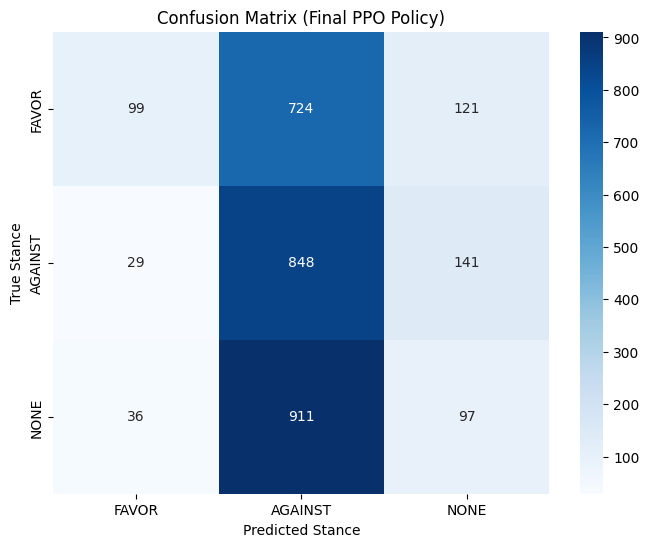


--- Pipeline Finished ---


In [ ]:
final_policy_net = PolicyNetwork(contrastive_model_path, device, NUM_ACTIONS).to(device)
final_policy_net.load_state_dict(torch.load(ppo_policy_model_path, map_location=device))
final_policy_net.eval()

final_test_dataset = PPODataset(df_test, tokenizer, MAX_LENGTH)
final_test_dataloader = DataLoader(final_test_dataset, batch_size=PPO_BATCH_SIZE * 2)

evaluate_model(final_policy_net, final_test_dataloader, None, device, "Final PPO Policy")

print("\n--- Pipeline Finished ---")